# Exploring Incomes in San Francisco

# Executive Summary

**THIS CELL IS WHERE YOU SHOULD WRITE A SHORT SUMMARY OF YOUR FINDINGS. THIS WILL OFTEN BE THE ONLY PART YOUR SUPERVISOR READS, SO MAKE IT WORTH THEIR TIME!**

All of the features were prepared for modelling. The numeric features were all transformed to approximately a standard normal distribution; they are all symmetrical with mean zero and a standard deviation of one. Several of the features had severe skew and required a Yeo-Johnson transformation. All of the transformations are reversible. The categorical columns were one-hot encoded. The `jobtitle` column had too many values to encode, but many of them occured just a few times. All job titles that occured 20 or fewer times were remapped to 'Other'; there were still 842 job titles that were one-hot encoded.

Before transformation, the data was explored for missing values. A number of values were erroneously mapped to zero when they should have been missing. Those values were dropped or filled as appropriate; some columns were filled with the median and some were filled using a KNNImputer from sci-kit learn.

The transformed data was saved as a `.parquet` file, ready to be loaded and used for down-stream modelling.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Data

This week's data is all about salaries for people working for the local government of San Francisco. It should give us some idea of how much people in the SF area earn for various jobs.

In [2]:
# do not change this cell!
data = pd.read_csv('https://raw.githubusercontent.com/JohnTheQuantYoutube/Bootcamp/main/Week3/Salaries.csv', low_memory=False)
data = data.rename(columns=str.lower)

In [3]:
# take a look at the data. Explore it however you want, but make sure you know what it means!
data.head()

,id,employeename,jobtitle,basepay,overtimepay,otherpay,benefits,totalpay,totalpaybenefits,year,notes,agency,status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [4]:
data.tail()

,id,employeename,jobtitle,basepay,overtimepay,otherpay,benefits,totalpay,totalpaybenefits,year,notes,agency,status
148649,148650,Roy I Tillery,Custodian,0.00,0.00,0.00,0.00,0.00,0.00,2014,NaN,San Francisco,PT
148650,148651,Not provided,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,NaN,San Francisco,NaN
148651,148652,Not provided,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,NaN,San Francisco,NaN
148652,148653,Not provided,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,NaN,San Francisco,NaN
148653,148654,Joe Lopez,"Counselor, Log Cabin Ranch",0.00,0.00,-618.13,0.00,-618.13,-618.13,2014,NaN,San Francisco,PT


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148654 entries, 0 to 148653
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                148654 non-null  int64  
 1   employeename      148654 non-null  object 
 2   jobtitle          148654 non-null  object 
 3   basepay           148049 non-null  object 
 4   overtimepay       148654 non-null  object 
 5   otherpay          148654 non-null  object 
 6   benefits          112495 non-null  object 
 7   totalpay          148654 non-null  float64
 8   totalpaybenefits  148654 non-null  float64
 9   year              148654 non-null  int64  
 10  notes             0 non-null       float64
 11  agency            148654 non-null  object 
 12  status            38119 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 14.7+ MB


**This cell is for you to explain what each column means and leave any initial thoughts you might have about how to approach them. Your thoughts will change as you work through the columns, but outlining your expectations now will help keep you on track as you go.**


0. `id` - This column is a unique identifier for each person. It should not be used for modelling, but we can use it to make the data anonymous, for safety.
1. `employeename` - This is the name of the person. We should not use this for modelling, and we might want to delete it entirely. However, maybe we could use it to make guesses at the person's gender or ethnicity, if we were inclined to explore salary equality.
2. `jobtitle` - This is the title of the job. It is definitely categorical. I am worried that it is high-cardinality and therefore not super useful for modelling.
3. `basepay` - This is the base annual salary, before bonuses or benefits or anything like that. It is probably in USD. This should be a floating point number with two decimal places (because it is in dollars). This should for sure be greater than zero, otherwise the person worked for free.
4. `overtimepay` - This is overtime pay, the amount this person got paid over the last year for working more than full-time hours. It is also in USD. This should be a floating point number with two decimal places.
5. `otherpay` - This is a catchall to capture all the money the person got paid that wasn't `basepay` or `overtimepay`. It should be in USD, a floating point number with two decimal places.
6. `benefits` - This is the financial value of the benefits the person recieved. It should be in USD, a floating point number with two decimal places. I'm worried that there are a LOT of missing values and that I won't know what to do about it :(
7. `totalpay` - This column should be the sum of the `basepay`, `overtimepay` and `otherpay` columns. It should not include benefits. It's in USD. This column is going to be highly correlated with the `pay` columns.
8. `totalpaybenefits` - This column should be the `totalpay` column plus the `benefits` column. It is going to be highly correlated with the `pay` columns and also the `benefits` column. It's in USD, and should have two decimal places.
9. `year` - The year the information was reported. This should be a four-digit integer. Should we treat it as a category? I don't know yet.
10. `notes` - This column is empty. Let's just delete it.
11. `agency` - This appears to be the city agency that the person works for. Although, it looks like maybe they're all just "San Francisco". Zero variation in the column implies zero information in the column, so if they're all the same we'll just drop it.
12. `status` - This column indicates if the person is full-time or part-time or whatever. It is a category. Maybe we can use this column to figure out how much each person got paid per-hour (assuming a 2,000 hour base salary schedule).

### Change Data Types

If you found any columns that you think ought to be a different type, go ahead and change them now! (Hint: I found a few columns that should be floats but were objects instead)

In [6]:
data['basepay'] = pd.to_numeric(data['basepay'], errors='coerce')
data['overtimepay'] = pd.to_numeric(data['overtimepay'], errors='coerce')
data['otherpay'] = pd.to_numeric(data['otherpay'], errors='coerce')
data['benefits'] = pd.to_numeric(data['benefits'], errors='coerce')

# Missing Values

Before we do anything else, we want to look for missing values. I have three things I usually do to check for missing values.

1. Use `.info()` to see what it says about "Non-Null" values
2. Use `.isna().sum()` to see how many missing values are already literally missing
3. Look at histograms to see if there's anything weird going on that might indicate missing or incorrect values.

I challenge you to do all three.

In [7]:
# use .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148654 entries, 0 to 148653
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                148654 non-null  int64  
 1   employeename      148654 non-null  object 
 2   jobtitle          148654 non-null  object 
 3   basepay           148045 non-null  float64
 4   overtimepay       148650 non-null  float64
 5   otherpay          148650 non-null  float64
 6   benefits          112491 non-null  float64
 7   totalpay          148654 non-null  float64
 8   totalpaybenefits  148654 non-null  float64
 9   year              148654 non-null  int64  
 10  notes             0 non-null       float64
 11  agency            148654 non-null  object 
 12  status            38119 non-null   object 
dtypes: float64(7), int64(2), object(4)
memory usage: 14.7+ MB


**What did `.info()` tell us about missing values?**

The `notes` column is empty, and the `status` column is almost completely empty too. `basepay` and `benefits` also have quite a few missing values.

In [8]:
# use isna
data.isna().sum()

,0
id,0
employeename,0
jobtitle,0
basepay,609
overtimepay,4
otherpay,4
benefits,36163
totalpay,0
totalpaybenefits,0
year,0


**What did `.isna().sum()` tell us about missing values?**

Yep, `notes` is empty and `status` is nearly empty. `basepay` is only missing a few values (in the grand scheme of things) and `benefits` is missing like 1/5 of the time.

In [9]:
# use histograms (it may help to set "stat = 'proportion'" in the parameters)
n = data.select_dtypes('number').shape[1]
print(f'There are {n} numeric columns.')

There are 9 numeric columns.


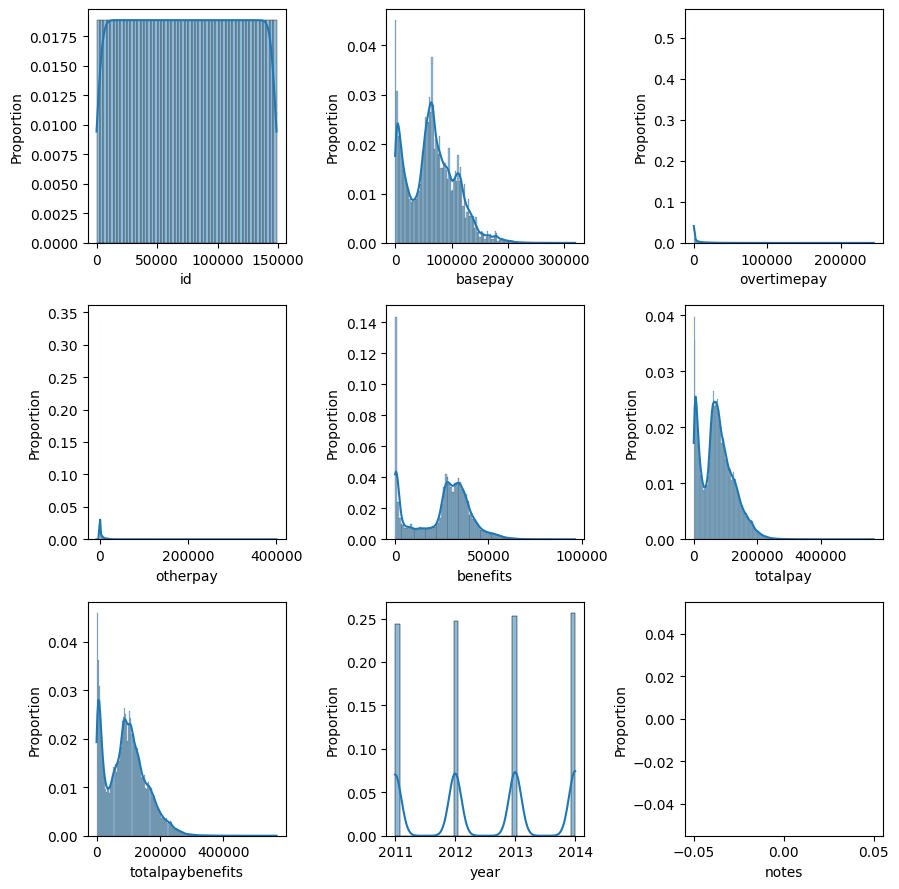

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
for i, col in enumerate(data.select_dtypes('number')):
    sns.histplot(data=data, x=col, kde=True, stat='proportion', ax=ax.flatten()[i])
fig.tight_layout()

**What do the histograms tell us about missing values?**

The `notes` column is empty. We need to get rid of it. There are people who have 0 `totalpay`. That can't be, right? It looks like maybe zeros got entered for people who didn't respond to the survey. We need to empty those zero values out and replace them as missing values. It also looks like they got more respondents each year, from 2011 to 2014.

### Create Missing Values

If you found any values that you think should be missing values instead, change them here. (Hint: I did, in several columns)

In [11]:
# change incorrect values to missing values
data.loc[data['basepay'] <= 0, 'basepay'] = np.nan
data.loc[data['overtimepay'] <= 0, 'overtimepay'] = np.nan
data.loc[data['otherpay'] <= 0, 'otherpay'] = np.nan
data.loc[data['benefits'] <= 0, 'benefits'] = np.nan
data.loc[data['totalpay'] <= 0, 'totalpay'] = np.nan
data.loc[data['totalpaybenefits'] <= 0, 'totalpaybenefits'] = np.nan

In [12]:
# check the number of missing values again
data.isna().sum()

,0
id,0
employeename,0
jobtitle,0
basepay,1918
overtimepay,77326
otherpay,41609
benefits,37901
totalpay,369
totalpaybenefits,34
year,0


## Handle Missing Values

**In this cell, come up with a plan for each column that has missing values. Are you going to drop them? Are you going to fill in with the mean or median or something like that? Are you going to impute the missing values? Explain why!**

If there are less than like 1,500 missing values, I'm just going to drop them. I am going to try filling in the `benefits` column with the mean and then check if that makes the distribution too weird. I'm going to drop the `notes` and `status` columns, and I might try imputing the `status` column and see what that looks like.

In [13]:
# drop missing values, if you're going to drop any
filled_data = data.copy()
filled_data = filled_data.drop(columns=['notes', 'status'])
filled_data = filled_data.dropna(subset=['totalpay', 'totalpaybenefits'])
filled_data.isna().sum()

,0
id,0
employeename,0
jobtitle,0
basepay,1549
overtimepay,76957
otherpay,41240
benefits,37867
totalpay,0
totalpaybenefits,0
year,0


In [14]:
# fill in missing values, if you're going to fill any
filled_data['basepay'] = filled_data['basepay'].fillna(filled_data['basepay'].median())
filled_data['overtimepay'] = filled_data['overtimepay'].fillna(0)
filled_data['otherpay'] = filled_data['otherpay'].fillna(0)
test_benefits = filled_data['benefits'].fillna(filled_data['benefits'].median())

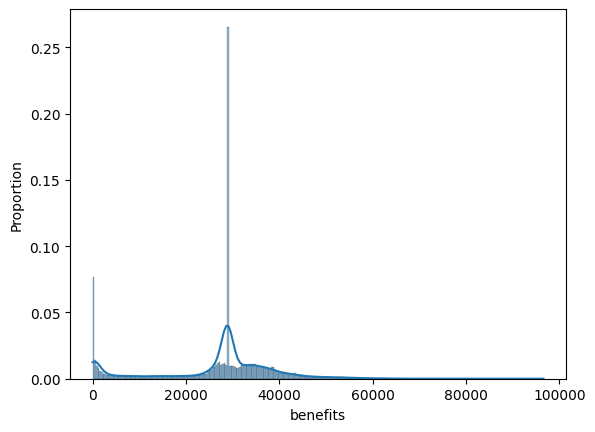

In [15]:
sns.histplot(test_benefits, kde=True, stat='proportion');

Filling in benefits with the median is too weird. I'll impute it instead.

In [16]:
# impute missing values, if you're going to impute any

# NOTE: This was not easy. This data is kind of big and the colab notebook
#       doesn't have that much memory. I've left hints for the biggest hurdles.
#       You can do this! Remember, my solution is available if you need it,
#       but try to do it on your own.

# HINT 1: You'll have to drop the `jobtitle`, `employeename`, and `id` columns

# HINT 2: You'll have to one-hot encode the string columns before this works!
#         Make a new DataFrame and encode the string columns,
#         then fit an imputer and get the new values,
#         then transfer them back to the original DataFrame

# IF YOU CAN'T MAKE IT WORK, THINK OF ANOTHER WAY TO FILL IN MISSING VALUES!
from sklearn.impute import KNNImputer

In [17]:
imputer_data = filled_data.copy()
imputer_data = imputer_data.drop(columns=['id', 'employeename', 'jobtitle'])
imputer_data = pd.get_dummies(imputer_data, drop_first=True)
imputer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148285 entries, 0 to 148625
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   basepay           148285 non-null  float64
 1   overtimepay       148285 non-null  float64
 2   otherpay          148285 non-null  float64
 3   benefits          110418 non-null  float64
 4   totalpay          148285 non-null  float64
 5   totalpaybenefits  148285 non-null  float64
 6   year              148285 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 9.1 MB


In [18]:
knn_imputer = KNNImputer()
knn_filled_data = knn_imputer.fit_transform(imputer_data)
knn_filled_data = pd.DataFrame(knn_filled_data, columns=imputer_data.columns)

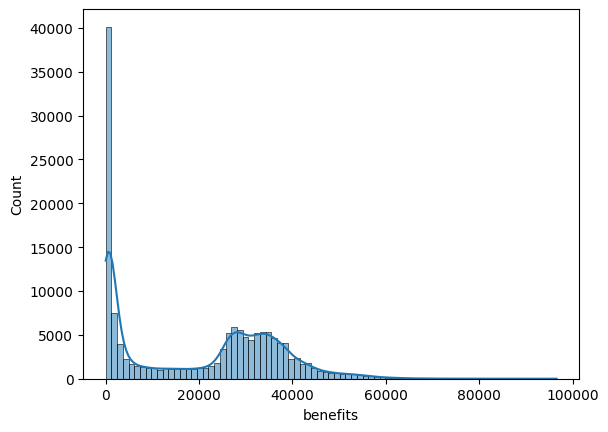

In [19]:
sns.histplot(knn_filled_data['benefits'], kde=True);

In [20]:
filled_data['benefits'] = knn_filled_data['benefits']

## Check Your Work!

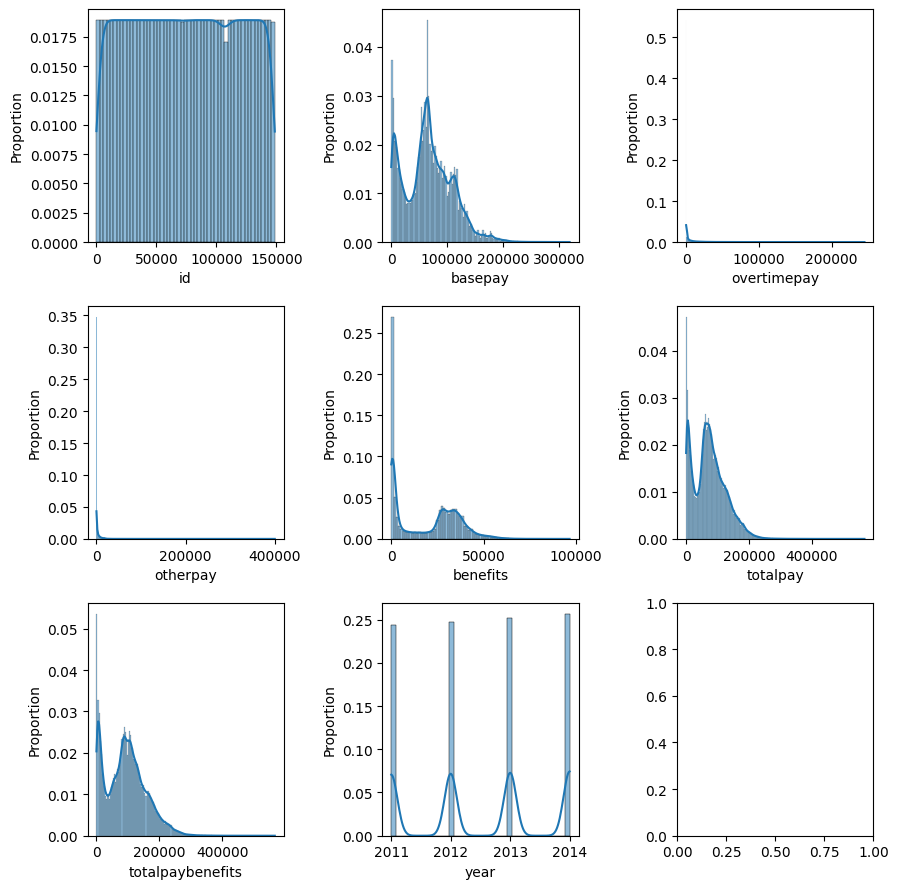

In [21]:
# redo histograms
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
for i, col in enumerate(filled_data.select_dtypes('number')):
    sns.histplot(data=filled_data, x=col, kde=True, stat='proportion', ax=ax.flatten()[i])
fig.tight_layout()

# Transforming Features

Start by splitting your data into two groups, categorical data or numeric data.
I've done it for you in the next cell.

In [22]:
# make a new transformed DataFrame, for later
transformed_data = filled_data.copy()
# split data between categorical or numeric
numeric_features = filled_data.select_dtypes('number').columns
numeric_data = filled_data[numeric_features].copy()
categorical_features = filled_data.select_dtypes(['category', 'object']).columns
categorical_data = filled_data[categorical_features].copy()

In [23]:
transformed_data[numeric_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 148285 entries, 0 to 148625
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                148285 non-null  int64  
 1   basepay           148285 non-null  float64
 2   overtimepay       148285 non-null  float64
 3   otherpay          148285 non-null  float64
 4   benefits          147944 non-null  float64
 5   totalpay          148285 non-null  float64
 6   totalpaybenefits  148285 non-null  float64
 7   year              148285 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 10.2 MB


In [24]:
transformed_data[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 148285 entries, 0 to 148625
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   employeename  148285 non-null  object
 1   jobtitle      148285 non-null  object
 2   agency        148285 non-null  object
dtypes: object(3)
memory usage: 4.5+ MB


## Make Numeric Features Symmetrical

**Go through each column of the `numeric_data` DataFrame and make them as symmetrical as possible. Remember the techniques we practiced in the lesson!**

(You don't have to worry about the `id` column)

### basepay

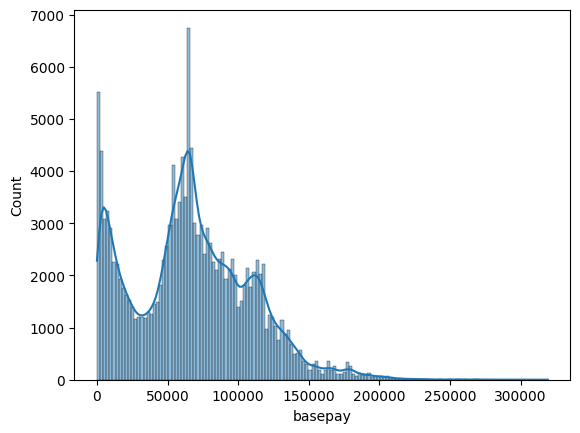

In [25]:
# start with a histogram
sns.histplot(numeric_data['basepay'], kde=True);

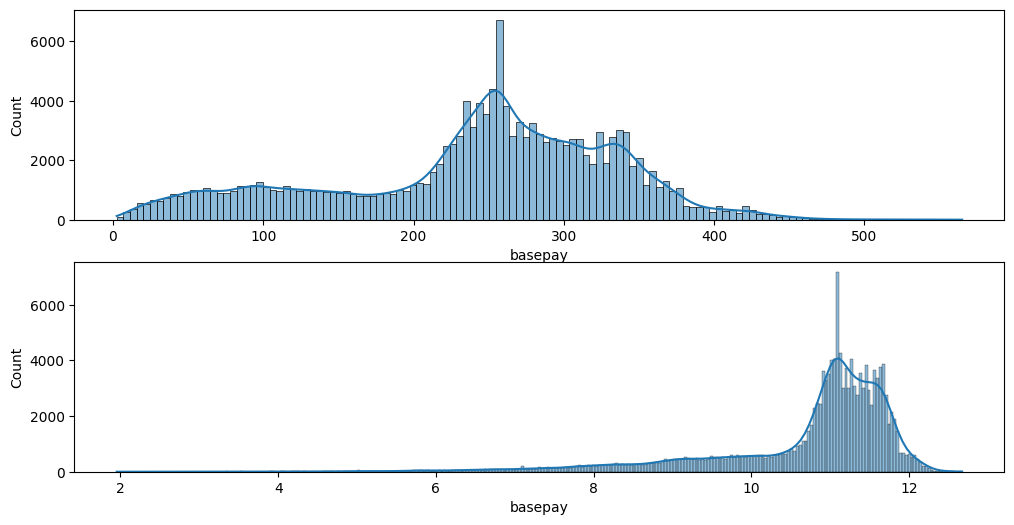

In [26]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
sns.histplot(np.sqrt(numeric_data['basepay']), kde=True, ax=ax[0])
sns.histplot(np.log(numeric_data['basepay']+1), kde=True, ax=ax[1]);

In [27]:
transformed_data['basepay'] = np.sqrt(numeric_data['basepay'])

**Explain why you chose this transformation for the `basepay` column.**

The `basepay` column had values below zero, but they were replaced with missing values and then filled with the average. The square root transformation looks much more symmetrical than the log transformation, and it is easily reversible.

After transformation, the `basepay` column looks *symetrical enough* that I thikn we can use it for modelling.

### overtimepay

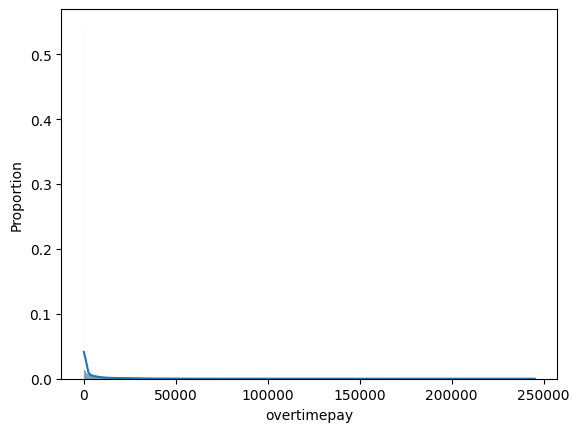

In [28]:
# start with a histogram
sns.histplot(numeric_data['overtimepay'], kde=True, stat='proportion');

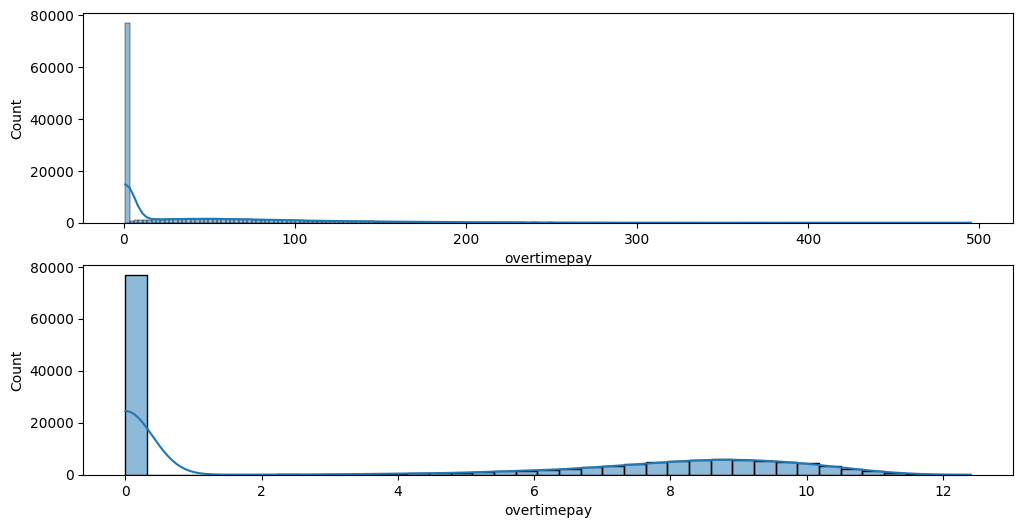

In [29]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
sns.histplot(np.sqrt(numeric_data['overtimepay']+1), kde=True, ax=ax[0])
sns.histplot(np.log(numeric_data['overtimepay']+1), kde=True, ax=ax[1]);

In [30]:
# I'm going to bucketize overtimepay. The buckets are 0 and not 0
transformed_data.loc[transformed_data['overtimepay'] == 0, 'overtimepay'] = 0
transformed_data.loc[transformed_data['overtimepay'] > 0, 'overtimepay'] = 1
transformed_data['overtimepay'] = transformed_data['overtimepay'].astype('category')

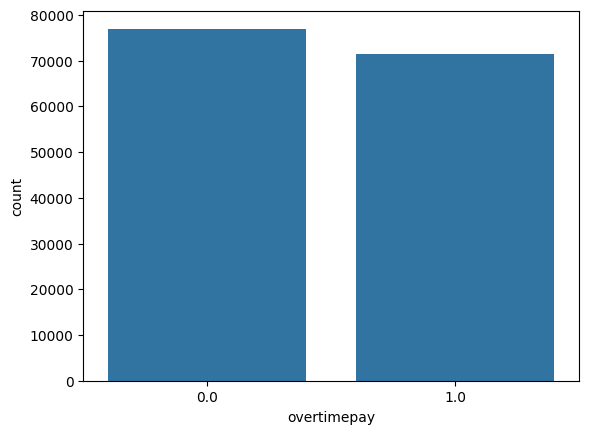

In [31]:
sns.barplot(transformed_data['overtimepay'].value_counts());

**Explain why you chose the transformation you chose for the `overtimepay` column.**

I chose to bucketize the `overtimepay` column. It was nearly 50/50 zeros and other values, and even though the other values had a nice symmetrical hump, they were so spread out that I don't think it would be very informative. I think most of the information in the original column would be captured by this binarization of the feature.

### otherpay

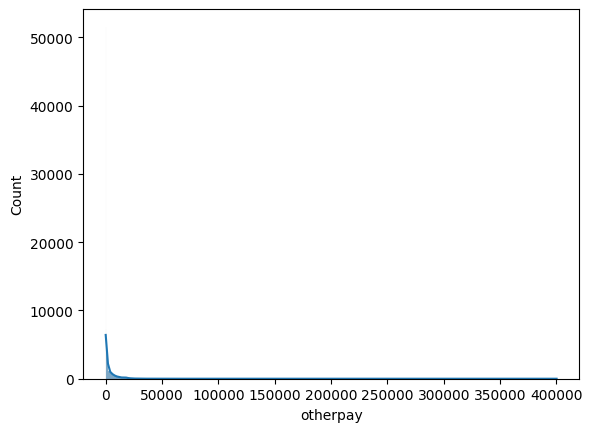

In [32]:
sns.histplot(numeric_data['otherpay'], kde=True);

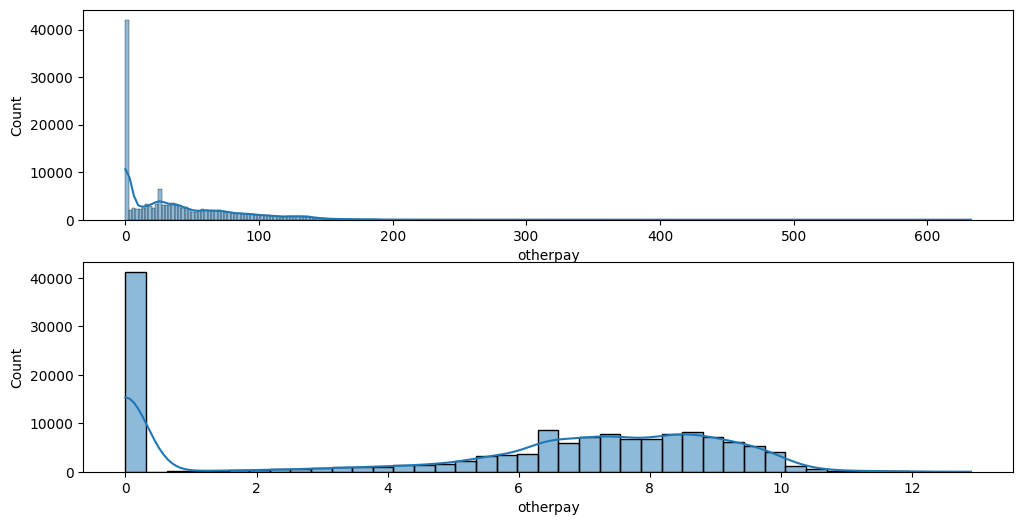

In [33]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
sns.histplot(np.sqrt(numeric_data['otherpay']), kde=True, ax=ax[0])
sns.histplot(np.log(numeric_data['otherpay']+1), kde=True, ax=ax[1]);

In [34]:
# bucketize this too
transformed_data.loc[transformed_data['otherpay'] == 0, 'otherpay'] = 0
transformed_data.loc[transformed_data['otherpay'] > 0, 'otherpay'] = 1
transformed_data['otherpay'] = transformed_data['otherpay'].astype('category')

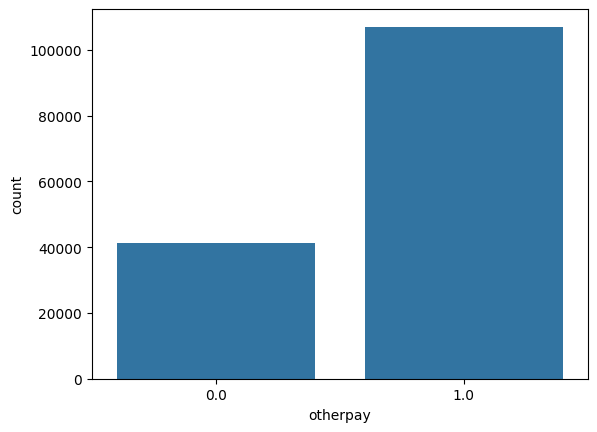

In [35]:
sns.barplot(transformed_data['otherpay'].value_counts());

**Explain why you chose this transformation for the `otherpay` column.**

I chose to bucketize the `otherpay` column for the same reason as `overtimepay`; there are a lot of zeros, and the non-zero values were quite spread out, so I believe that the binarized variable will have most of the same information and be easier for a model to understand.

### benefits

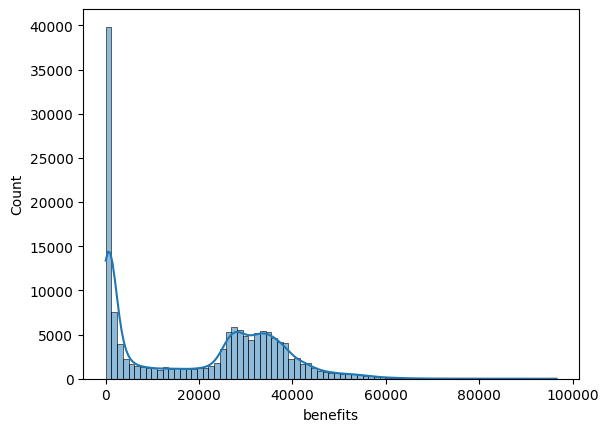

In [36]:
sns.histplot(filled_data['benefits'], kde=True);

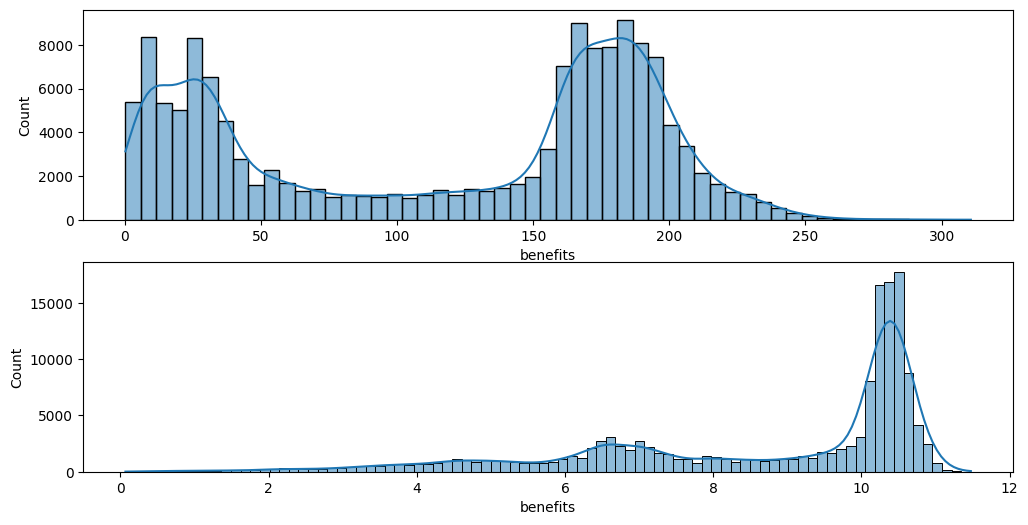

In [37]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
sns.histplot(np.sqrt(filled_data['benefits']), kde=True, ax=ax[0])
sns.histplot(np.log(filled_data['benefits']+1), kde=True, ax=ax[1]);

In [38]:
# I want to see the skew from each of these
print(np.sqrt(filled_data['benefits']).skew())
print(np.log(filled_data['benefits'] + 1).skew())

-0.2808303618839282
-1.1250139135035049


In [39]:
# try a Yeo-Johnson transformation
from sklearn.preprocessing import PowerTransformer

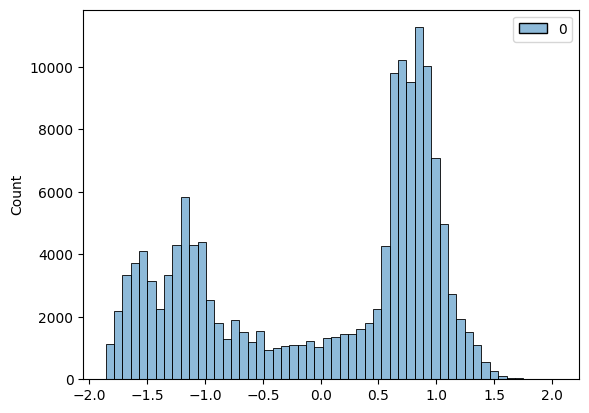

In [40]:
benefits_transformer = PowerTransformer(method='yeo-johnson')
benefits_transformed = benefits_transformer.fit_transform(filled_data[['benefits']])
sns.histplot(benefits_transformed);

In [41]:
pd.Series(benefits_transformed.flatten()).skew();

In [42]:
transformed_data['benefits'] = benefits_transformed

**Explain why you chose this transformation for the `benefits` column.**

The `benefits` column looks like it is probably pretty informative, but it is very skewed. Neither a square-root transformation not a log transformation was strong enough to make it symmetrical, so I did a Yeo-Johnson Transformation, which helped enough to make the feature look useable.

### totalpay

In [43]:
total_pay = filled_data['basepay'] + filled_data['overtimepay'] + filled_data['otherpay']
total_pay.isna().sum()

0

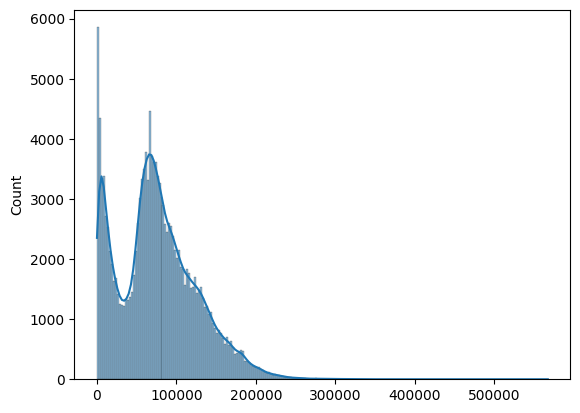

In [44]:
sns.histplot(total_pay, kde=True);

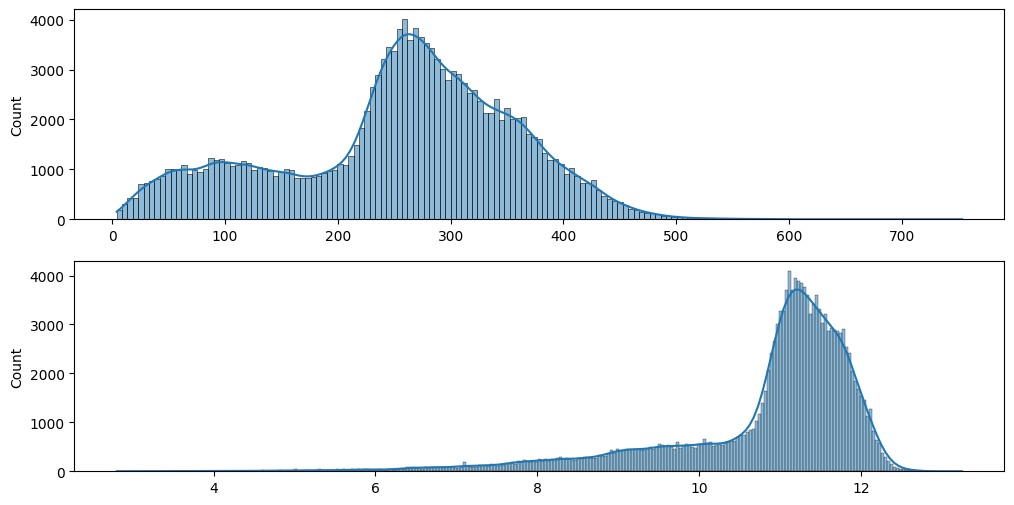

In [45]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
sns.histplot(np.sqrt(total_pay), kde=True, ax=ax[0])
sns.histplot(np.log(total_pay+1), kde=True, ax=ax[1]);

In [46]:
transformed_data['totalpay'] = np.sqrt(total_pay)

**Explain why you chose this transformation for the `totalpay` column.**

I recreated the `totalpay` column because I'd filled in values in `basepay`, `overtimepay`, and `otherpay` columns, and I want `totalpay` to be the sum of those three.

My recreated column was right-skewed. I tried both a square-root transformation and a log transformation. The log transformation was too powerful and actually made it left-skewed, but the square-root transformation looks *somewhat* symmetrical, so that's what I'm sticking with.

When we scale all of the columns later, this feature will be a good one.

### totalpaybenefits

In [47]:
total_pay_benefits = filled_data['totalpay'] + filled_data['benefits']
total_pay_benefits.isna().sum()
total_pay_benefits[total_pay_benefits.isna()] = filled_data.loc[total_pay_benefits.isna(), 'totalpay']

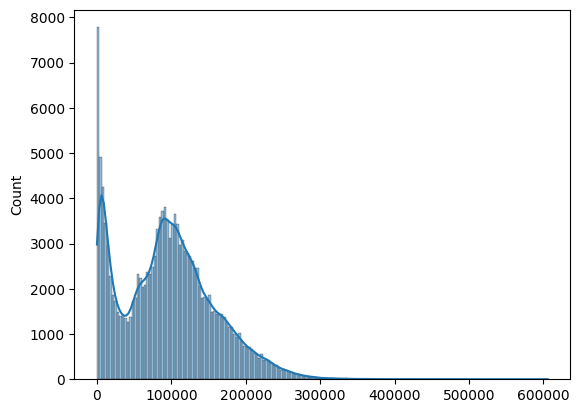

In [48]:
sns.histplot(total_pay_benefits, kde=True);

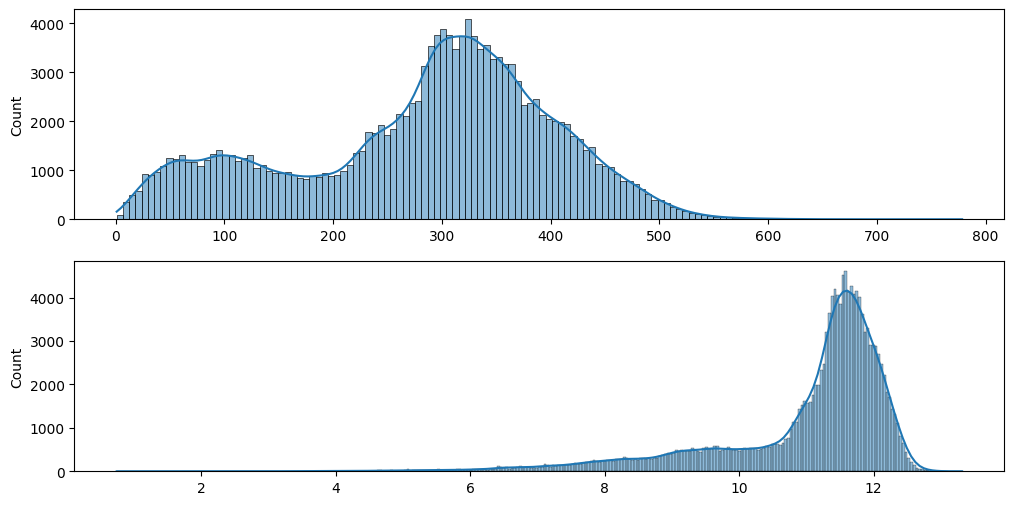

In [49]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
sns.histplot(np.sqrt(total_pay_benefits), kde=True, ax=ax[0])
sns.histplot(np.log(total_pay_benefits+1), kde=True, ax=ax[1]);

In [50]:
transformed_data['totalpaybenefits'] = np.sqrt(total_pay_benefits)

**Explain why you chose this transformation for the `totalpaybenefits` column.**

I recreated this column as well, because I recreated the `totalpay` column and I filled missing values in the `benefits` column, and I want this column to be the sum of those two.

The recreated column was right-skewed, but a square-root transformation looks like it works pretty well.

### year

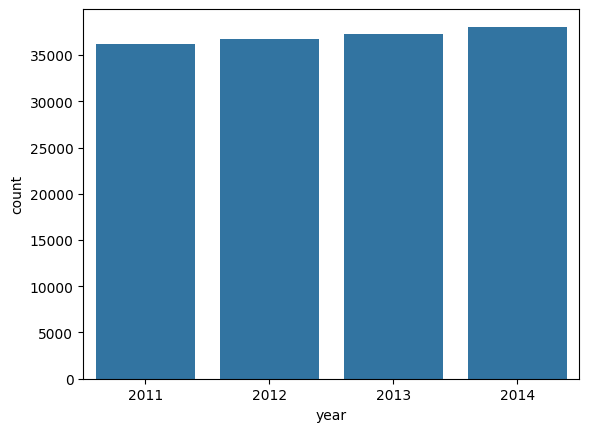

In [51]:
sns.barplot(filled_data['year'].value_counts());

In [52]:
transformed_data['year'] = filled_data['year']

**Explain why you chose this transformation for the `year` column.**

I didn't do a transformation, but I suppose I could have subtracted 2011, setting the year to [0, 1, 2, 3]. I didn't worry about it.

## Scale Numeric Features

We want all of our features centered over zero and with standard deviation = 1. This emsures that no feature can overwhelm the others simply by having bigger numbers. Scale the numeric features all at once!

In [53]:
# import standardscaler here
from sklearn.preprocessing import StandardScaler

In [54]:
# scale the numeric data (watch out for the `id` column)
numeric_data = numeric_data.drop(['year', 'id'], axis=1)
numeric_scaler = StandardScaler()
numeric_scaled = numeric_scaler.fit_transform(numeric_data)
numeric_scaled = pd.DataFrame(numeric_scaled, columns=numeric_data.columns)
transformed_data[numeric_data.columns] = numeric_scaled

## Categorical Features

The only way of handling categorical features that we talked about in the lesson was **One-Hot Encoding**. Go through the columns, decide whether you want to drop the column, **one-hot encode** it, or use some other kind of encoding (Google it!).

### employeename

In [55]:
transformed_data = transformed_data.drop(columns=['employeename'])

**Explain why you chose to handle `employeename` the way you did.**

I don't think this column is useful, and in fact it might be *dangerous* to use it in our model! If the employee's name contains information on gender or race, then using it to build a model can create implicit bias in the model, and we don't want that. That's why I dropped it.

### jobtitle

The `jobtitle` column has way too many values to just one-hot encode. It'll be overwhelming. So, let's replace the *uncommon* job titles with 'Other'. How many times should a job title exist in the dataset for you to think it is meaningful? Pick a number. Remember we have like 150,000 rows.

Pick a number yourself. It's okay to guess and see how many job titles your number would eliminate. I am going to leave my code below, because this is a little tough. I chose to replace job titles that appeared 20 or fewer times, but you might decide that a different number is better.

In [56]:
categorical_data['jobtitle'].value_counts().sort_values()

,count
jobtitle,
Cashier 3,1
TRANSIT POWER LINE WORKER SUPERVISOR II,1
ASST. CHIEF PROBATION OFFICER-JUVENILE PROBATION,1
"ASST. CHIEF, BUREAU OF CLAIMS INVEST. & ADMIN",1
HEAD AIRPORT ELECTRICIAN,1
...,...
Police Officer 3,2417
Public Svc Aide-Public Works,2516
Registered Nurse,3734


In [57]:
uncommon_jobs = categorical_data['jobtitle'].value_counts().sort_values()[categorical_data['jobtitle'].value_counts().sort_values() <= 20].index
categorical_data.loc[categorical_data['jobtitle'].isin(uncommon_jobs), 'jobtitle'] = 'Other'

In [58]:
transformed_data = transformed_data.drop(columns=['jobtitle'])
job_titles = pd.get_dummies(categorical_data['jobtitle'], drop_first=True) * 1
transformed_data = pd.concat([transformed_data, job_titles], axis=1)

**Explain why you handled the `jobtitle` column the way you did.**

I suspect that `jobtitle` is going to be very important for predicting salary and benefits, etc. I wish we had something like an industry or role column instead of `jobtitle`, but this is the closest we've got. I want the information from this column, so I am one-hot encoding it.

Another interesting option might have been to use some form of embedding to cluster jobs with semantically similar titles. That would probably make a huge difference in our model's accuracy.

### agency

In [59]:
categorical_data['agency'].value_counts()

,count
agency,
San Francisco,148285


In [60]:
transformed_data = transformed_data.drop(columns=['agency'])

**Explain why you handled the `agency` column the way you did.**

This column only had one value. No variation implies no information, so I just dropped it.

# Look at the Data Now

Evaluate the data after all the transformations, check for missing values again, and just make sure your data looks like what you think it should look like.

In [61]:
# examine the head
transformed_data.describe()

,id,basepay,overtimepay,otherpay,benefits,totalpay,totalpaybenefits,year,ACCOUNTANT INTERN,ADMINISTRATIVE ANALYST,...,Water QualityTech I/II,Water Service Inspector,Watershed Keeper,Watershed Worker (Seasonal),Welder,Window Cleaner,Wire Rope Cable Maint Mechanic,Worker's Compensation Adjuster,X-RAY LABORATORY AIDE,X-Ray Laboratory Aide
count,148285.000000,147944.000000,147944.000000,147944.000000,147603.000000,147944.000000,147944.000000,148285.000000,148285.000000,148285.000000,...,148285.000000,148285.000000,148285.000000,148285.000000,148285.000000,148285.000000,148285.000000,148285.000000,148285.000000,148285.000000
mean,74239.440483,0.002980,0.000612,0.000787,0.002468,0.002836,0.002913,2012.521307,0.000324,0.000627,...,0.000452,0.000553,0.000513,0.000580,0.000256,0.000337,0.000196,0.000499,0.000175,0.000674
std,42919.609576,0.998703,0.998657,1.000498,0.999458,0.998569,0.998543,1.118338,0.017989,0.025036,...,0.021252,0.023509,0.022633,0.024076,0.016006,0.018360,0.013983,0.022334,0.013240,0.025960
min,1.000000,-1.582563,-0.442934,-0.453574,-1.182956,-1.485958,-1.497253,2011.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37075.000000,-0.719316,-0.442934,-0.453574,-1.118677,-0.749534,-0.775717,2012.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74171.000000,-0.038841,-0.442934,-0.351431,0.284223,-0.064996,-0.018843,2013.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,111530.000000,0.657563,-0.033038,0.075334,0.829627,0.616737,0.625264,2014.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,148626.000000,5.970657,20.936706,49.169970,4.603672,9.766563,7.552304,2014.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
# examine the tail
transformed_data.tail()

,id,basepay,overtimepay,otherpay,benefits,totalpay,totalpaybenefits,year,ACCOUNTANT INTERN,ADMINISTRATIVE ANALYST,...,Water QualityTech I/II,Water Service Inspector,Watershed Keeper,Watershed Worker (Seasonal),Welder,Window Cleaner,Wire Rope Cable Maint Mechanic,Worker's Compensation Adjuster,X-RAY LABORATORY AIDE,X-Ray Laboratory Aide
148621,148622,NaN,NaN,NaN,NaN,NaN,NaN,2014,0,0,...,0,0,0,0,0,0,0,0,0,0
148622,148623,NaN,NaN,NaN,NaN,NaN,NaN,2014,0,0,...,0,0,0,0,0,0,0,0,0,0
148623,148624,NaN,NaN,NaN,NaN,NaN,NaN,2014,0,0,...,0,0,0,0,0,0,0,0,0,0
148624,148625,NaN,NaN,NaN,NaN,NaN,NaN,2014,0,0,...,0,0,0,0,0,0,0,0,0,0
148625,148626,NaN,NaN,NaN,NaN,NaN,NaN,2014,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# look at the info
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148285 entries, 0 to 148625
Columns: 849 entries, id to X-Ray Laboratory Aide
dtypes: float64(6), int64(843)
memory usage: 965.7 MB


In [64]:
# count missing values.
# Remember to sort the Series so you can see where the missing values are!
transformed_data.isna().sum().sort_values()

,0
id,0
Pharmacy Technician,0
Physical Therapist,0
Physician Assistant,0
Physician Specialist,0
...,...
totalpay,341
otherpay,341
overtimepay,341
basepay,341


If anything doesn't look like what you expected, or if there are missing values after the transformation, try to figure out what happened. Some common sources of missign values are if you tried a square-root transformation when there are negative numbers in the column, or if you tried a log transformation on a column with zeros.



In [65]:
# fix problems here

# I had less than 1000 missing values afterward, so I'll just drop them.
transformed_data = transformed_data.dropna()

# Save Transformed Data

It would suck to have done this much work and then lose it, so go ahead and save the transformed data and download the file and keep it somewhere you can find it.

I chose to use a `.parquet` file because this is kind of a big dataset and those files are smaller and faster than `.csv`, but you can't read a `.parquet` file and neither can Excel, so there are benefits to using `.csv` instead if you want.

In [66]:
transformed_data.to_parquet('week3_transformed_data.parquet')

## Correlation

Check to see how correlated your transformed features are. Mine had like 850 columns, which is waaaay too many. We only need to check the columns that were originally numeric. Hopefully you remember what they are!

In [67]:
# look at the correlation matrix
transformed_data[numeric_features].corr()

,id,basepay,overtimepay,otherpay,benefits,totalpay,totalpaybenefits,year
id,1.000000,-0.199133,-0.078807,-0.097707,0.231684,-0.203141,-0.082194,0.968302
basepay,-0.199133,1.000000,0.262478,0.286878,0.672063,0.944797,0.936507,0.030768
overtimepay,-0.078807,0.262478,1.000000,0.315049,0.346739,0.504030,0.466857,0.026013
otherpay,-0.097707,0.286878,0.315049,1.000000,0.269830,0.469480,0.420899,-0.004564
benefits,0.231684,0.672063,0.346739,0.269830,1.000000,0.698520,0.813381,0.412215
totalpay,-0.203141,0.944797,0.504030,0.469480,0.698520,1.000000,0.976977,0.033293
totalpaybenefits,-0.082194,0.936507,0.466857,0.420899,0.813381,0.976977,1.000000,0.154555
year,0.968302,0.030768,0.026013,-0.004564,0.412215,0.033293,0.154555,1.000000


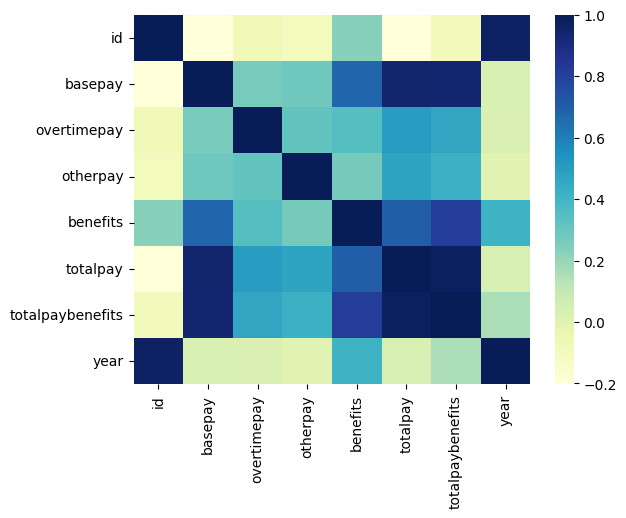

In [68]:
# make a heatmap of the correlation, too!
sns.heatmap(transformed_data[numeric_features].corr(), cmap='YlGnBu');

There are features with way too much correlation! What should we do?

Google it and see if there are any good ideas online!

# Principal Component Analysis

**Principal Component Analysis**, or **PCA**, is probably the most common way to get rid of correlation among features. We will talk more about what it *means* next week. For now, just run **PCA** on your transformed DataFrame, using the `.fit_transform()` method from sci-kit learn!

In [70]:
# import PCA
from sklearn.decomposition import PCA

In [73]:
# run PCA
pca = PCA()
pca_data = pca.fit_transform(transformed_data[numeric_features])
pca_data = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, pca_data.shape[1]+1)])

In [75]:
# check the PCA data for correlation
pca_data.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
PC1,1.000000e+00,2.394531e-16,-2.125361e-16,-9.032217e-18,1.154916e-16,-3.467382e-16,7.824820e-16,-5.570292e-16
PC2,2.394531e-16,1.000000e+00,7.932437e-16,9.905314e-17,-2.742774e-16,-7.313687e-17,4.337943e-16,-5.957523e-16
PC3,-2.125361e-16,7.932437e-16,1.000000e+00,-2.529591e-16,2.752672e-16,1.167121e-16,6.168705e-17,-1.332127e-17
PC4,-9.032217e-18,9.905314e-17,-2.529591e-16,1.000000e+00,6.033060e-16,-1.766152e-16,2.148212e-16,-3.006299e-16
PC5,1.154916e-16,-2.742774e-16,2.752672e-16,6.033060e-16,1.000000e+00,-6.828602e-16,1.325946e-15,2.212122e-15
PC6,-3.467382e-16,-7.313687e-17,1.167121e-16,-1.766152e-16,-6.828602e-16,1.000000e+00,-5.686551e-16,3.595950e-16
PC7,7.824820e-16,4.337943e-16,6.168705e-17,2.148212e-16,1.325946e-15,-5.686551e-16,1.000000e+00,1.584219e-16
PC8,-5.570292e-16,-5.957523e-16,-1.332127e-17,-3.006299e-16,2.212122e-15,3.595950e-16,1.584219e-16,1.000000e+00


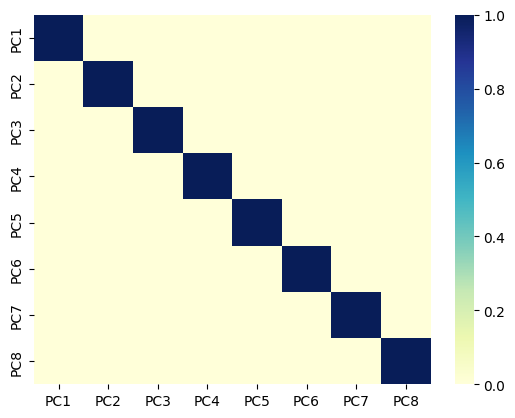

In [76]:
# and make a heatmap
sns.heatmap(pca_data.corr(), cmap='YlGnBu');

**PCA** removed ALL of the correlation from our highly correlated numeric dataset!